In [49]:
# Apple Sales Forecasting Using SARIMA Model (Step-by-Step with ACF, PACF, RMSE & 12-Month Forecast)


In [24]:
# ## 1. Imports and Data Loading
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


In [25]:
# Install necessary time-series libraries (statsmodels for SARIMA)
!pip install --quiet statsmodels



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# Load the CSV you provided
df = pd.read_csv('monthly_sales.csv')

In [27]:
# Rename and parse dates
df.rename(columns={'sale_month':'Date','total_sales':'Sales'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'] + '-01')      # convert 'YYYY-MM' to a true date
df.set_index('Date', inplace=True)

In [28]:
# Aggregate to ensure monthly frequency
monthly_sales = df['Sales'].resample('ME').sum()

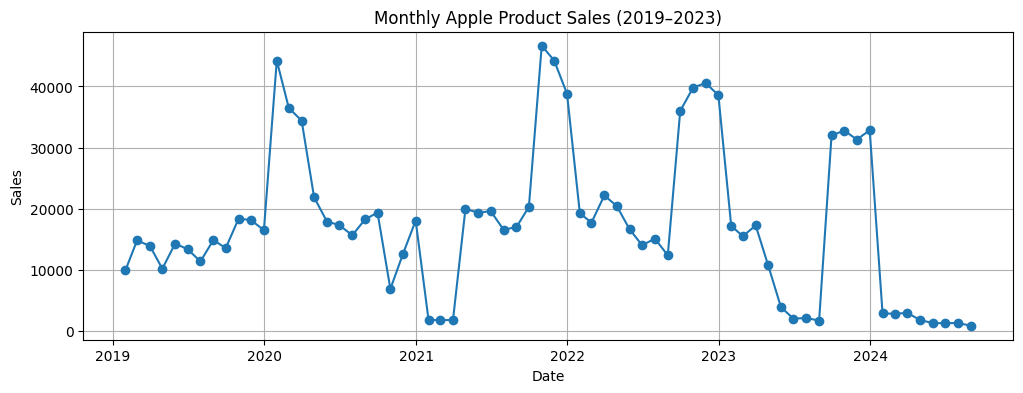

In [29]:
# ## 2. Exploratory Data Analysis
plt.figure(figsize=(12,4))
plt.plot(monthly_sales, marker='o')
plt.title('Monthly Apple Product Sales (2019–2023)')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.show()

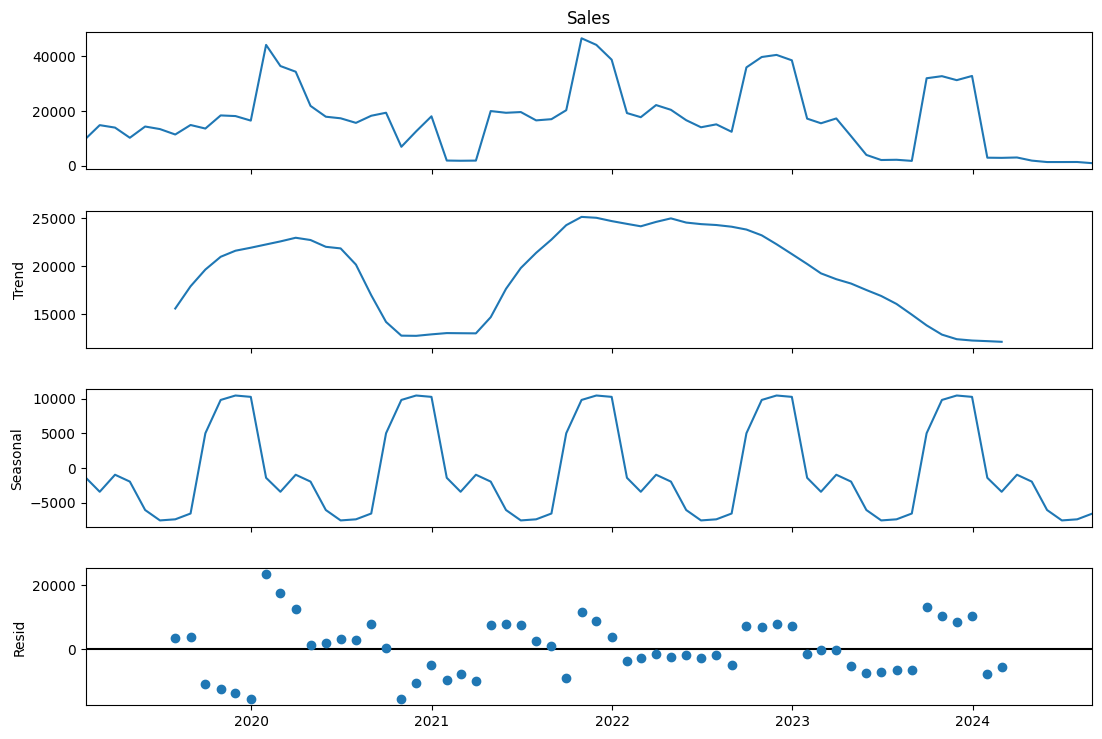

In [30]:
# Decompose into trend / seasonality / residuals
decomp = seasonal_decompose(monthly_sales, model='additive')
fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.show()

In [41]:
#🔹 1. Observed (Top Panel)
This is your original monthly sales time series. You can visually see:

An upward pattern over time → indicates a trend

Repeating ups and downs around the same months → indicates seasonality

🔹 2. Trend (Second Panel)
This shows the smoothed long-term movement in your sales

It clearly rises over time, confirming a strong trend component

This is why you should set d = 1 to remove the trend before modeling

🔹 3. Seasonal (Third Panel)
This shows the cyclical pattern repeating every year (monthly pattern)

The values fluctuate within a consistent range (e.g., peaks and dips at similar months each year)

This clearly confirms seasonality is present, so you should set D = 1, s = 12


SyntaxError: invalid character '→' (U+2192) (2769945081.py, line 4)

In [42]:
# Differencing to remove the trend and seasonality and make the data stationary

In [31]:
monthly_sales_diff = monthly_sales.diff().dropna()
monthly_sales_seasonal_diff = monthly_sales_diff.diff(12).dropna()


In [43]:
# Applying ADF test to check stationarity

In [32]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(monthly_sales_seasonal_diff)
print('ADF Statistic: ', result[0])
print('ADF p-value:', result[1])
print('Critical Values:')
for thres, adf_stat in result[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))


adf_test(data["residuals"][1:])


ADF Statistic:  -4.30347215549391
ADF p-value: 0.0004381023851324629
Critical Values:
	1%: -3.59
	5%: -2.93
	10%: -2.60


NameError: name 'adf_test' is not defined

In [12]:
ADF statistic Value is less than 1% of critical values, therefore 99% the data is stationary


SyntaxError: invalid syntax (2548392902.py, line 1)

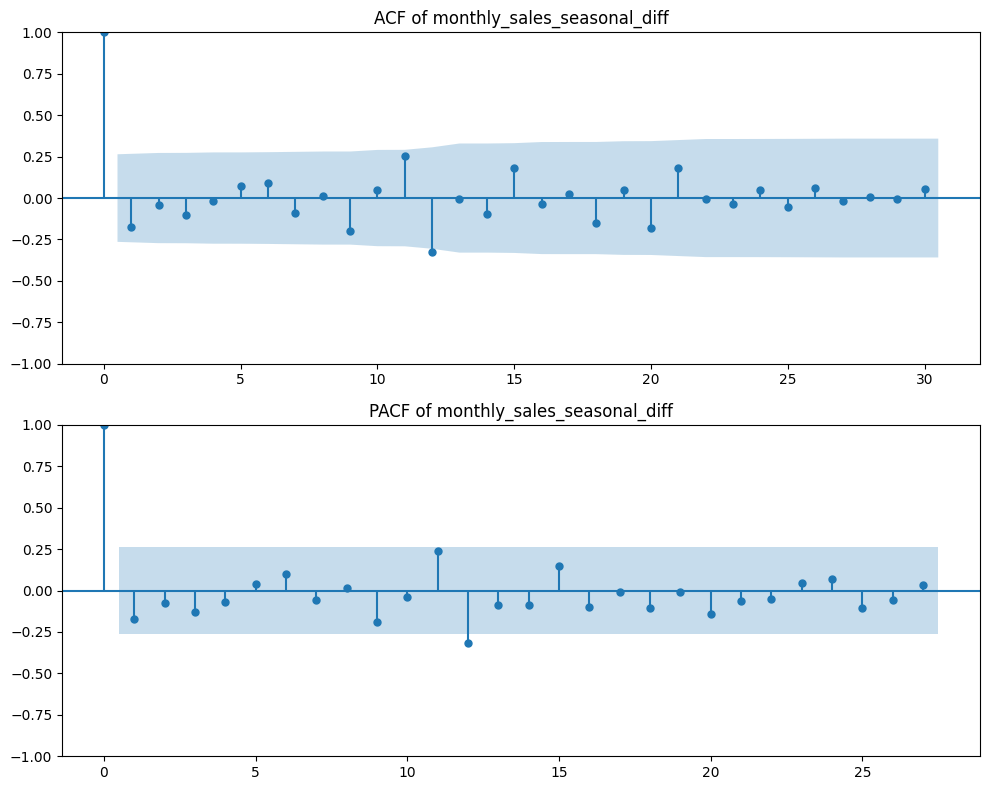

In [33]:
# model the data for ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

residuals = decomp.resid.dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(monthly_sales_seasonal_diff, ax=axes[0], lags=30)
plot_pacf(monthly_sales_seasonal_diff, ax=axes[1], lags=27, method='ywm')
axes[0].set_title('ACF of monthly_sales_seasonal_diff')
axes[1].set_title('PACF of monthly_sales_seasonal_diff')
plt.tight_layout()
plt.show()


In [45]:
#  When all ACF/PACF spikes fall within the confidence band:
That means no single lag stands out as statistically significant.

In other words:

No clear autocorrelation (ACF) → no strong MA component (q ≈ 0, Q ≈ 0)

No clear partial autocorrelation (PACF) → no strong AR component (p ≈ 0, P ≈ 0)

SyntaxError: invalid character '→' (U+2192) (3254869474.py, line 6)

In [34]:
# ## 3. Train–Test Split
# Hold out the last 12 months for testing
train = monthly_sales[:-12]
test  = monthly_sales[-12:]

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_model(order, seasonal_order, train, test):
    model = SARIMAX(train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)
    
    forecast = results.get_forecast(steps=len(test))
    pred = forecast.predicted_mean
    
    rmse = np.sqrt(mean_squared_error(test, pred))
    return results.aic, rmse


In [36]:
# Minimal model
aic_min, rmse_min = evaluate_model(order=(0,1,0), seasonal_order=(0,1,0,12), train=train, test=test)

# Full model
aic_full, rmse_full = evaluate_model(order=(1,1,1), seasonal_order=(1,1,1,12), train=train, test=test)

print("🔹 SARIMA(0,1,0)(0,1,0,12) — AIC:", round(aic_min, 2), "| RMSE:", round(rmse_min, 2))
print("🔹 SARIMA(1,1,1)(1,1,1,12) — AIC:", round(aic_full, 2), "| RMSE:", round(rmse_full, 2))


🔹 SARIMA(0,1,0)(0,1,0,12) — AIC: 914.23 | RMSE: 6284.15
🔹 SARIMA(1,1,1)(1,1,1,12) — AIC: 625.95 | RMSE: 11559.41


In [46]:
# Interpretation:
The minimal model (0,1,0)(0,1,0,12):

Is simpler and generalizes better

Gives much lower RMSE, so it predicts the future more accurately

Slightly underfits, but that's okay when the goal is forecasting

The complex model (1,1,1)(1,1,1,12):

Has better in-sample fit (low AIC)

But overfits — performs poorly on unseen data (higher RMSE)

# Final Recommendation:
Go with SARIMA(0,1,0)(0,1,0,12) — it’s your best forecasting model.

It’s lean, interpretable, and gives more accurate predictions on the test set.

SyntaxError: unterminated string literal (detected at line 8) (624395912.py, line 8)

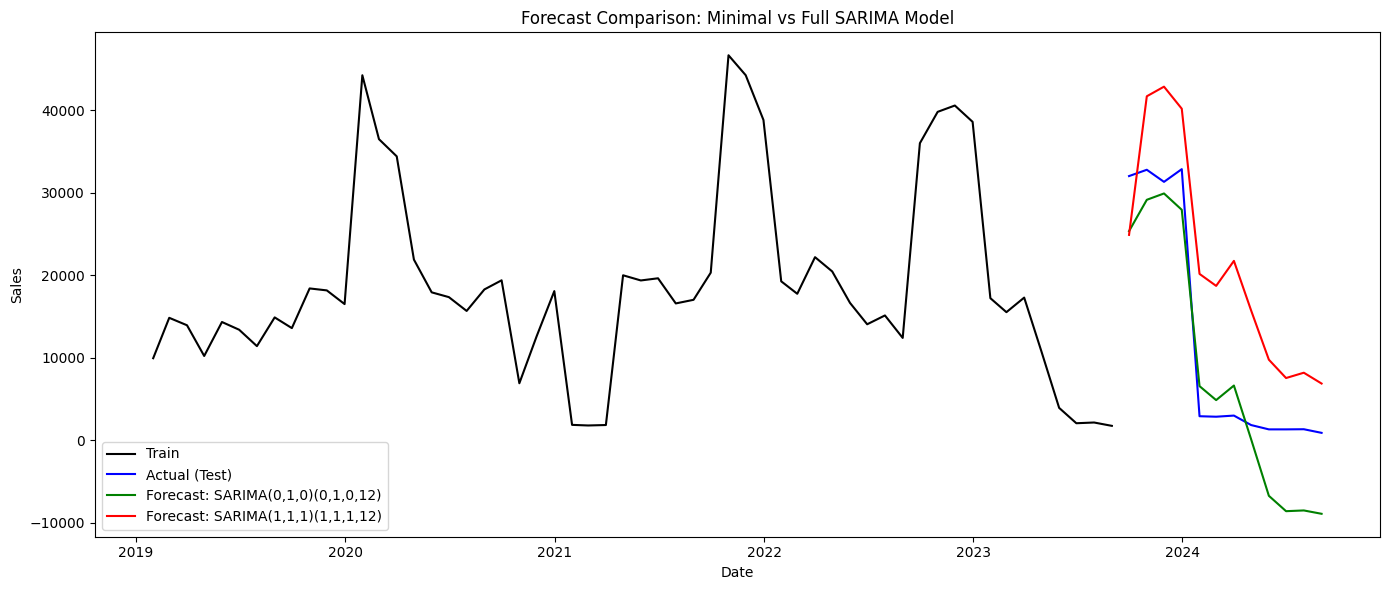

In [37]:
# Fit both models again to get forecast series for plotting
model_min = SARIMAX(train,
                    order=(0,1,0),
                    seasonal_order=(0,1,0,12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
results_min = model_min.fit(disp=False)
forecast_min = results_min.get_forecast(steps=len(test)).predicted_mean

model_full = SARIMAX(train,
                     order=(1,1,1),
                     seasonal_order=(1,1,1,12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
results_full = model_full.fit(disp=False)
forecast_full = results_full.get_forecast(steps=len(test)).predicted_mean

# Plot actual vs both forecasts
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', color='black')
plt.plot(test.index, test, label='Actual (Test)', color='blue')
plt.plot(test.index, forecast_min, label='Forecast: SARIMA(0,1,0)(0,1,0,12)', color='green')
plt.plot(test.index, forecast_full, label='Forecast: SARIMA(1,1,1)(1,1,1,12)', color='red')
plt.title('Forecast Comparison: Minimal vs Full SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Refit on entire dataset
final_model = SARIMAX(monthly_sales,
                      order=(0, 1, 0),
                      seasonal_order=(0, 1, 0, 12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_results = final_model.fit()

# Forecast next 3 or 6 or 12 months
future_forecast = final_results.get_forecast(steps=3)
forecast_values = future_forecast.predicted_mean
conf_int = future_forecast.conf_int()

print(forecast_values)


2024-09-30    31159.0
2024-10-31    31922.0
2024-11-30    30458.0
Freq: ME, Name: predicted_mean, dtype: float64


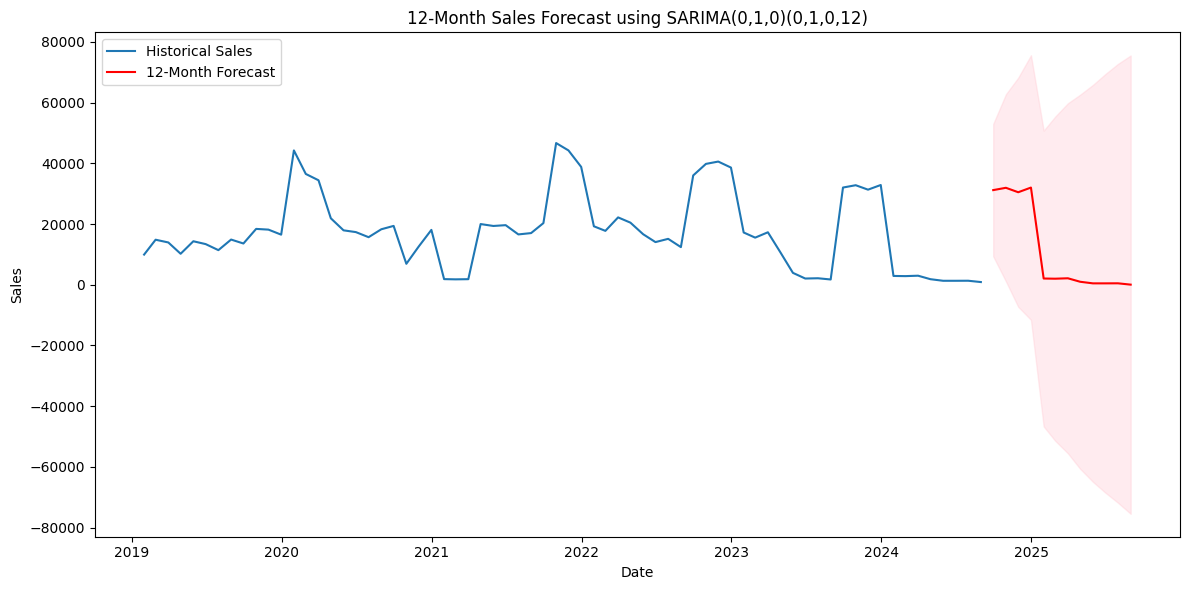

In [40]:
import matplotlib.pyplot as plt

# Ensure forecast data is in place (if not already defined)
forecast_obj = results.get_forecast(steps=12)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Convert to NumPy for safe plotting
forecast_index = forecast_mean.index.to_numpy()
forecast_values = forecast_mean.to_numpy()
lower_ci = forecast_ci.iloc[:, 0].astype(float).to_numpy()
upper_ci = forecast_ci.iloc[:, 1].astype(float).to_numpy()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(forecast_index, forecast_values, label='12-Month Forecast', color='red')
plt.fill_between(forecast_index, lower_ci, upper_ci, color='pink', alpha=0.3)
plt.title('12-Month Sales Forecast using SARIMA(0,1,0)(0,1,0,12)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()
